# imports

In [9]:
from os.path import join as pjoin
import datetime
import os
import re

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

from torchmetrics.classification import MulticlassAccuracy, MulticlassPrecision, MulticlassRecall

import matplotlib.pyplot as plt

import torchvision
from torchvision import transforms
from torchvision.io import read_image

import torchinfo

# Константы


In [10]:
createLogFolder = True
WEIGHT_SAVER = "last" # "all" / "nothing" / "last"
epochs = 55
NUM_WORKERS = 0

batch_size = 128
CLASSES = np.array( ['abraham_grampa_simpson', 'agnes_skinner', 'apu_nahasapeemapetilon', 'barney_gumble', 'bart_simpson',
    'carl_carlson', 'charles_montgomery_burns', 'chief_wiggum', 'cletus_spuckler', 'comic_book_guy', 'disco_stu',
    'edna_krabappel', 'fat_tony', 'gil', 'groundskeeper_willie', 'homer_simpson', 'kent_brockman', 'krusty_the_clown', 'lenny_leonard',
    'lionel_hutz', 'lisa_simpson', 'maggie_simpson', 'marge_simpson', 'martin_prince', 'mayor_quimby', 'milhouse_van_houten', 'miss_hoover',
    'moe_szyslak', 'ned_flanders', 'nelson_muntz', 'otto_mann', 'patty_bouvier', 'principal_skinner', 'professor_john_frink', 'rainier_wolfcastle',
    'ralph_wiggum', 'selma_bouvier', 'sideshow_bob', 'sideshow_mel', 'snake_jailbird', 'troy_mcclure', 'waylon_smithers'])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = CLASSES.shape[0]
IMAGE_RESIZE = (64, 64)

learnLogFile = None
logLearnFolder = None

NORMALIZE_MEAN = (0.5, 0.5, 0.5)
NORMALIZE_DEVIATIONS = (0.5, 0.5, 0.5)

# Transformers

In [11]:
transform = torchvision.transforms.Compose([
    # torchvision.transforms.ToPILImage(),
    transforms.Resize(IMAGE_RESIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(NORMALIZE_MEAN, NORMALIZE_DEVIATIONS),
])

class LabelTransformer():
    def __init__(self, initial_list = CLASSES):
        self.initial_list = initial_list
    
    def __call__(self, val):
        if type(val) == str:
            return self.toInt(val)
        elif type(val) == int or type(val) == np.int64:
            return self.toStr(val)
        return None

    def toInt(self, label : str) -> int:
        return np.where(self.initial_list == label)[0][0]
    
    def toStr(self, ind : int) -> str:
        return self.initial_list[ind]

# Датасет
Train + Valid

In [12]:
full_dataset = torchvision.datasets.ImageFolder(root="dataset/characters/", transform=transform)
generator=torch.Generator().manual_seed(42)
train_dataset, valid_dataset = torch.utils.data.random_split(full_dataset, [0.8, 0.2], generator=generator)

## Предпросмотр датасета


<Figure size 640x480 with 0 Axes>

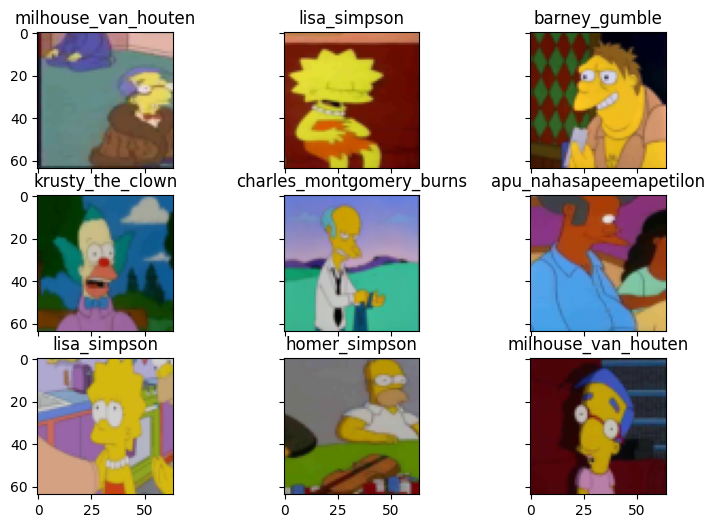

In [13]:
figure = plt.figure()

def imshow(img, title, plt_ax=plt):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array(NORMALIZE_MEAN)
    std = np.array(NORMALIZE_DEVIATIONS)
    img = std * img + mean
    plt_ax.imshow(img)
    plt_ax.set_title(title)
    plt_ax.grid(False)

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(9, 6), sharey=True, sharex=True)

for fig_x in ax.flatten():
    character_index = int(np.random.uniform(0, len(train_dataset)))
    img, label = train_dataset[character_index]
    label = LabelTransformer()(label)
    imshow(img.data.cpu(), title=label, plt_ax=fig_x)

# Модель

In [14]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.MaxPool2d(2)
        )

        self.shuffle1 = nn.Sequential(nn.Sequential(
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True)
        ), nn.Sequential(
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True))
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.MaxPool2d(2)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.MaxPool2d(2)
        )

        self.shuffle2 = nn.Sequential(nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True)
        ), nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True))
        )

        self.conv5 = nn.Sequential(
            nn.Conv2d(512, 1024, 3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(True),
            nn.MaxPool2d(2)
        )

        self.res = nn.Sequential(
            nn.MaxPool2d(4),
            nn.Flatten(),
            nn.Linear(1024, 512),
            nn.Linear(512, 128),
            nn.Linear(128, len(CLASSES)),
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.shuffle1(x) + x
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.shuffle2(x) + x
        x = self.conv5(x)
        x = self.res(x)
        return x


# Dataloader's

In [16]:
model = Model()
trained = False

# if torch.cuda.device_count() > 1:
#     print("Using", torch.cuda.device_count(), "GPUs")
#     model = nn.DataParallel(model)

model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    params=model.parameters(),
    lr=0.01,
    momentum=0.9,
)

scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, threshold=1e-2, cooldown=1)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=NUM_WORKERS,
)
valid_dataloader = DataLoader(
    dataset=valid_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=NUM_WORKERS,
)


print(model_sum := torchinfo.summary(model, input_size=(batch_size, 3, *IMAGE_RESIZE), row_settings=["var_names"], verbose=0, col_names=[
      "input_size", "output_size", "num_params", "params_percent", "kernel_size", "mult_adds", "trainable"]))


Layer (type (var_name))                  Input Shape               Output Shape              Param #                   Param %                   Kernel Shape              Mult-Adds                 Trainable
Model (Model)                            [128, 3, 64, 64]          [128, 42]                 --                             --                   --                        --                        True
├─Sequential (conv1)                     [128, 3, 64, 64]          [128, 64, 64, 64]         --                             --                   --                        --                        True
│    └─Conv2d (0)                        [128, 3, 64, 64]          [128, 64, 64, 64]         1,792                       0.02%                   [3, 3]                    939,524,096               True
│    └─BatchNorm2d (1)                   [128, 64, 64, 64]         [128, 64, 64, 64]         128                         0.00%                   --                        16,384          

In [ ]:
if createLogFolder:
    logLearnFolder = f"{os.path.abspath('.')}/log [{epochs}] {datetime.datetime.now().replace(microsecond=0)}"
    os.makedirs(logLearnFolder)
    logLearnFileName = f"{logLearnFolder}/log.txt"
    learnLogFile = open(logLearnFileName, 'w', encoding='utf8')
    learnLogFile.write(str(model_sum))
    learnLogFile.write('\n')


# Шаг обучения и валидации

In [ ]:

def train_step():
    model.train()
    running_loss = 0.
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss

    with torch.no_grad():
        train_loss = running_loss / len(train_dataloader)
    return train_loss.item()

def valid_step():
    model.eval()
    acc = MulticlassAccuracy(num_classes=len(CLASSES), average="micro")
    recall = MulticlassRecall(num_classes=len(CLASSES), average="macro")
    precision = MulticlassPrecision(num_classes=len(CLASSES), average="macro")
    acc.to(device)
    recall.to(device)
    precision.to(device)

    running_loss = 0.

    with torch.no_grad():
        for images, labels in valid_dataloader:
            images = images.to(device)
            labels = labels.to(device)

            output = model(images)

            acc.update(output, labels)
            recall.update(output, labels)
            precision.update(output, labels)

            loss = criterion(output, labels)
            running_loss += loss

        valid_loss = running_loss / len(valid_dataloader)

        return valid_loss.item(), acc.compute().item(), recall.compute().item(), precision.compute().item()

train_losses = []
valid_losses = []
valid_accs = []
valid_recs = []
valid_precs = []
lrs = []

# Цикл обучения

In [ ]:
from tqdm import tqdm

best_loss = 10000

trained = True

for epoch in (pbar := tqdm(range(epochs))):
    train_loss = train_step()
    valid_loss, valid_acc, valid_recall, valid_precision = valid_step()
    scheduler.step(valid_loss)

    if WEIGHT_SAVER != "nothing" and valid_loss < best_loss and epoch > 3:
        best_loss = valid_loss

        print(f"Saved weights with acc/rec/prec: {valid_acc:.2f}/{valid_recall:.2f}/{valid_precision:.2f} | loss: {valid_loss:.4f}")
        if learnLogFile is not None:
            learnLogFile.write(
                f"Saved weights with acc/rec/prec: {valid_acc:.2f}/{valid_recall:.2f}/{valid_precision:.2f}")
            learnLogFile.write(f"| loss: {valid_loss:.4f}\n")

        if WEIGHT_SAVER == "all":
            torch.save(model.state_dict(),
                       f"{logLearnFolder}/weights_{epoch}.pth")
        elif WEIGHT_SAVER == "last":
            torch.save(model.state_dict(),
                       f"{logLearnFolder}/weights_last.pth")

    for i, param_group in enumerate(optimizer.param_groups):
        lrs.append(float(param_group['lr']))
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    valid_recs.append(valid_recall)
    valid_precs.append(valid_precision)

    if learnLogFile is not None:
        learnLogFile.write(
            f"[{epoch}] acc/rec/prec: {valid_acc:.2f}/{valid_recall:.2f}/{valid_precision:.2f} ")
        learnLogFile.write(f"| train/valid loss: {train_loss:.4f}/{valid_loss:.4f}\n")
    pbar.set_description(
        f'acc/rec/prec: {valid_acc:.2f}/{valid_recall:.2f}/{valid_precision:.2f}  | train/valid loss: {train_loss:.4f}/{valid_loss:.4f}')

if learnLogFile is not None:
    learnLogFile.close()


# Отображение графиков

### learning rate

In [ ]:
fig = plt.figure(figsize=(8, 5))

plt.plot(lrs, label='learning rate')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Learning rate')
if logLearnFolder is not None: plt.savefig(f"{logLearnFolder}/lr.png")
plt.show()

### loss

In [ ]:
fig = plt.figure(figsize=(8, 5))

plt.plot(np.arange(3, len(train_losses)), train_losses[3:], label='train')
plt.plot(np.arange(3, len(valid_losses)), valid_losses[3:], label='valid')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Loss')
if logLearnFolder is not None: plt.savefig(f"{logLearnFolder}/loss.png")
plt.show()

### metrics

In [ ]:
fig = plt.figure(figsize=(8, 5))

plt.plot([0] + valid_accs, label='accuracy')
plt.plot([0] + valid_precs, label='precision')
plt.plot([0] + valid_recs, label='recall')
plt.legend()
plt.grid(True)
plt.yticks(np.arange(0, 1, 0.05))
plt.xlabel('Iterations')
plt.ylabel('Ratio')
if logLearnFolder is not None: plt.savefig(f"{logLearnFolder}/valid_metrics.png")
plt.show()

# Проверка на тестовом датасете

### Tranform + dataset class

In [ ]:
transform = torchvision.transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(IMAGE_RESIZE),
    transforms.ToTensor(),
    transforms.Normalize(NORMALIZE_MEAN, NORMALIZE_DEVIATIONS),
])


class SimpsonsTestDataset(Dataset):
    def __init__(self, img_dir, transform=None, label_transform=None):
        self.files = []
        for r, dir, files in os.walk(img_dir):
            self.files += files
        self.calculateClasses()
        self.img_dir = img_dir
        self.transform = transform
        self.label_transform = label_transform

    def extractName(self, s):
        se = re.search(r"[a-zA-Z_]+[^\d]?", s)
        return se.group(0)[:-1]

    def calculateClasses(self):
        self.s = set()
        for i in self.files:
            self.s.add(self.extractName(i))
        return list(self.s)

    @property
    def classes(self):
        return list(self.s)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        img_path = pjoin(self.img_dir, self.files[index])
        image = read_image(img_path)
        label = self.extractName(self.files[index])

        if self.transform:
            image = self.transform(image)
        if self.label_transform:
            label = self.label_transform(label)
        return image, label


## Проверка

In [ ]:
test_dataset = SimpsonsTestDataset(
    "dataset/kaggle_simpson_testset", transform=transform, label_transform=LabelTransformer())

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
)

if not trained:
    model = Model()
    model.to(device)
    model.load_state_dict(torch.load(
        "/home/e.babenko1/AI_Tasks/01_Task/2SufflesWeights5Convs [43ep].pth"))


def test_metrics_per_class(model, testloader, dataset = None):
    classes = CLASSES
    classes_amount = len(CLASSES)

    acc = MulticlassAccuracy(num_classes=classes_amount, average=None)
    recall = MulticlassRecall(num_classes=classes_amount, average=None)
    precision = MulticlassPrecision(num_classes=classes_amount, average=None)
    acc.to(device)
    recall.to(device)
    precision.to(device)

    with torch.no_grad():
        model.eval()
        for images, labels in testloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            acc.update(outputs, labels)
            recall.update(outputs, labels)
            precision.update(outputs, labels)

    
    accuracy_per_class = {classname: val.item()
                          for classname, val in zip(classes, acc.compute())}
    recall_per_class = {classname: val.item()
                        for classname, val in zip(classes, recall.compute())}
    precision_per_class = {classname: val.item()
                           for classname, val in zip(classes, precision.compute())}
    try:
        classes_amount_correct = len(dataset.classes)
        classes_correct = dataset.classes
        print("Recalculate metrics with correct dataset classes")

        slice_dict = lambda dict, sliceBy: {k:dict[k] for k in dict if k in sliceBy}
        accuracy_per_class = slice_dict(accuracy_per_class, classes_correct)
        recall_per_class = slice_dict(recall_per_class, classes_correct)
        precision_per_class = slice_dict(precision_per_class, classes_correct)

        total_acc = sum(acc.compute())/classes_amount_correct
        total_rec = sum(recall.compute())/classes_amount_correct
        total_prec = sum(precision.compute())/classes_amount_correct
    except:
        total_acc = sum(acc.compute())/classes_amount
        total_rec = sum(recall.compute())/classes_amount
        total_prec = sum(precision.compute())/classes_amount
    return {"accuracy": accuracy_per_class, "recall": recall_per_class, "precision": precision_per_class}, {"accuracy": total_acc, "recall": total_rec, "precision": total_prec}


metrics_per_class, metrics_total = test_metrics_per_class(
    model, test_dataloader, test_dataset)
print(metrics_per_class)


## Отобразить

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(25,8))

for (metricName, mVal), ax in zip(metrics_per_class.items(), axes):
    plt.sca(ax)
    plt.bar(mVal.keys(), mVal.values())
    plt.title(metricName)
    plt.grid(axis='y')
    plt.xticks(rotation=90)
    plt.yticks(ticks=np.arange(0, 1.01, 0.05))
if logLearnFolder is not None: plt.savefig(f"{logLearnFolder}/test_metricBars.png")
plt.show()

result = f"""\n\nTest:
accuracy: {metrics_total['accuracy']:.2f}
recall: {metrics_total['recall']:.2f}
precision: {metrics_total['precision']:.2f}
F: {2 * metrics_total['precision']*metrics_total['recall']/(metrics_total['precision']+metrics_total['recall']):.2f}"""

print(result)
if learnLogFile is not None:
    learnLogFile.write(result)
    learnLogFile.write("\n")